In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import gc
import math
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import functools

import random

import librosa.display, librosa

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,file_name,text
0,001/hobby_00000002,요샌 당신만 생각납니다. 나는 당신을 사랑하는 것 같습니다. 나와 결혼해 주십시오....
1,001/hobby_00000003,안녕하세요. 고객님. 저는 상담사 이지혜입니다. 제가 좋은 보험 하나 소개시켜주고 ...
2,001/hobby_00000005,오늘 점심으로 칼국수 끓이려고 하는데 괜찮아요?
3,001/hobby_00000007,우리 토요일 날 노는 날이니까 요번에 엄마 산소 한 번 갔다 오는 게 어딨겠어 여보?
4,001/hobby_00000009,강원도는 하루 종일 비가 왔는데 서울은 어땠어?


In [5]:
submission.head()

,file_name,text
0,dialog_00000001,음성인식
1,dialog_00000002,음성인식
2,dialog_00000003,음성인식
3,dialog_00000004,음성인식
4,dialog_00000005,음성인식


In [6]:
class Custom_Tokenizer():
    def __init__(self, max_length, max_vocab_size=-1):
        self.txt2idx = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}
        self.idx2txt = {0:'<pad>', 1:'<unk>', 2:'<sos>', 3:'<eos>'}
        self.max_length = max_length
        self.char_count = {}
        self.max_vocab_size = max_vocab_size
        
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for char in sentence:
                self.char_count[char] = self.char_count.get(char, 0) + 1
        self.char_count = dict(sorted(self.char_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}
        self.idx2txt = {0:'<pad>', 1:'<unk>', 2:'<sos>', 3:'<eos>'}
        if self.max_vocab_size == -1:
            for i, char in enumerate(list(self.char_count.keys())):
                self.txt2idx[char] = i+4
                self.idx2txt[i+4] = char
        else:
            for i, char in enumerate(list(self.char_count.keys())[:self.max_vocab_size]):
                self.txt2idx[char] = i+4
                self.idx2txt[i+4] = char
        
    def sort_target(self, x):
        return x[1]
    
    def txt2token(self, sentence_list):
        tokens = []
        for j, sentence in tqdm(enumerate(sentence_list)):
            token = [0]*(self.max_length+2)
            token[0] = self.txt2idx['<sos>']
            for i, c in enumerate(sentence):
                if i == self.max_length:
                    break
                try:
                    token[i+1] = self.txt2idx[c]
                except:
                    token[i+1] = self.txt2idx['<unk>']
            try:
                token[i+2] = self.txt2idx['<eos>']
            except:
                pass
            tokens.append(token)
        return tokens
    
    def convert(self, token):
        sentence = []
        for i in token:
            if i == self.txt2idx['<eos>'] or i == self.txt2idx['<pad>']:
                break
            elif i != 0:
                sentence.append(self.idx2txt[i])
        sentence = "".join(sentence)
        sentence = sentence[5:]
            
        return sentence

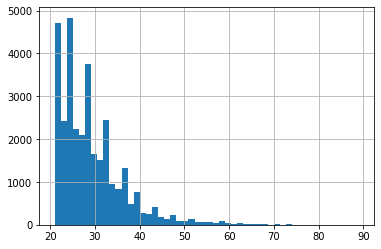

In [7]:
train.text.str.len().hist(bins=50)
plt.show()

In [8]:
max_length = 30
tokenizer = Custom_Tokenizer(max_length=max_length, max_vocab_size=-1)
tokenizer.fit(train.text)

100%|█████████████████████████████████| 32454/32454 [00:00<00:00, 169644.34it/s]


In [9]:
target_size = len(tokenizer.txt2idx)
target_size

1417

In [10]:
tokens = tokenizer.txt2token(train.text)

32454it [00:00, 156467.22it/s]


In [11]:
np.array(tokens)

array([[  2,  12, 735, ...,  60, 110,   0],
       [  2,  62, 465, ...,  11,   4,   0],
       [  2,  52,  94, ...,   0,   0,   0],
       ...,
       [  2, 137,  81, ...,  12,   5,   3],
       [  2,  11, 237, ...,   4, 270,   0],
       [  2, 143,  19, ...,   0,   0,   0]])

In [12]:
i = 123
print(f'원본: {train.text[i]}')
print(f'복원: {tokenizer.convert(tokens[i])}')

원본: 소나무 키가 많이 컸다. 저 앞집 거실이 안 보이네?
복원: 소나무 키가 많이 컸다. 저 앞집 거실이 안 보이네?


In [13]:
class CustomDataset(Dataset):
    def __init__(self, path_list, target_list, save_path, sound_max_length=160000, mode='train'):
        self.hop_length = 512
        self.n_fft = 512
        self.sr = 16000
        self.hop_length_duration = float(self.hop_length) / self.sr
        self.n_fft_duration = float(self.n_fft) / self.sr
        self.sound_max_length = sound_max_length
        self.save_path = save_path
        
        self.mode = mode
        self.path_list = path_list
        
        if self.mode == 'train':
            self.target_list = target_list
            
        if not os.path.exists(save_path):
            os.mkdir(save_path)
            
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, i):
        try:
            magnitude = np.load(f'{self.save_path}/magnitude_{i}.npy')
        except:
            data, rate = librosa.load(self.path_list[i])
            sound = np.zeros(self.sound_max_length)
            if len(data) <= self.sound_max_length:
                sound[:data.shape[0]] = data
            else:
                sound = data[:self.sound_max_length]
            stft = librosa.stft(sound, n_fft=self.n_fft, hop_length=self.hop_length)
            magnitude = np.abs(stft).astype(np.float32)
            np.save(f'{self.save_path}/magnitude_{i}.npy', magnitude)
        magnitude_ = np.zeros([magnitude.shape[0],magnitude.shape[1],3])
        magnitude_[:,:,0] = magnitude
        magnitude_[:,:,1] = magnitude
        magnitude_[:,:,2] = magnitude
        
        magnitude = np.transpose(magnitude_, (2,0,1))
        
        if self.mode == 'train':
            target = self.target_list[i]
            return {
                'magnitude' : torch.tensor(magnitude, dtype=torch.float32),
                'target' : torch.tensor(target, dtype=torch.long)
            }
        else:
            return {
                'magnitude' : torch.tensor(magnitude, dtype=torch.float32)
            }

In [14]:
path_list = (train.file_name +'.wav').to_numpy()
path_list.shape, np.array(tokens).shape

((32454,), (32454, 32))

In [15]:
batch_size = 32
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 20
learning_rate = 5e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch.device: {device}')

path_list, tokens = shuffle(path_list, tokens, random_state=42)

train_path_list = list(map(lambda x: os.path.join('train_data', x), path_list[:-5000]))
val_path_list = list(map(lambda x: os.path.join('train_data', x), path_list[-5000:]))

train_tokens = tokens[:-5000]
val_tokens = tokens[-5000:]

test_path_list = 'test_data/' + submission['file_name'] + '.wav'

train_dataset = CustomDataset(train_path_list, train_tokens, 'train_encoder_input_data')
val_dataset = CustomDataset(val_path_list, val_tokens, 'val_encoder_input_data')
test_dataset = CustomDataset(test_path_list, None, 'test_encoder_input_data', 160000, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

train_dataset[0]['magnitude'].size(), test_dataset[0]['magnitude'].size()

torch.device: cuda:0


(torch.Size([3, 257, 313]), torch.Size([3, 257, 313]))

In [16]:
sample_batch = next(iter(train_dataloader))
sample_batch['magnitude'].size(), sample_batch['target'].size()

(torch.Size([32, 3, 257, 313]), torch.Size([32, 32]))

In [17]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return torch.tensor(pos_encoding, dtype=torch.float32)

In [19]:
def create_padding_mask(seq):
    seq = torch.tensor(torch.eq(seq, 0), dtype=torch.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    seq = seq.unsqueeze(1).unsqueeze(2)
    return seq  # (batch_size, 1, 1, seq_len)

In [20]:
def create_look_ahead_mask(size):
    mask = torch.ones(size, size).triu(diagonal=1)
    return mask  # (seq_len, seq_len)

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, torch.transpose(k, -2, -1))  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = k.size()[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [22]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)
        
    def forward(self, v, k, q, mask):
        batch_size = q.size()[0]
        
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = scaled_attention.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.depth)
                
        output = self.wo(scaled_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [24]:
class FFN(nn.Module):
    def __init__(self, d_model, dff):
        super(FFN, self).__init__()
        self.layer1 = nn.Linear(d_model, dff)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(dff, d_model)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.fc(x)

        return x

In [25]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        
    def forward(self, x, enc_output=None):
        if enc_output == None:
            x = self.feature_extract_model(x)
            x = x.permute(0,2,3,1)
            x = x.view(x.size()[0], -1, x.size()[3])
            x = self.dropout(x)
            x = nn.ReLU()(self.fc(x))
        else:
            x = enc_output
        return x

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = FFN(d_model, dff)
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)
        
        self.layernorms1 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms2 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms3 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorms1[x.size(1)-1](attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorms2[x.size(1)-1](attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorms3[x.size(1)-1](ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [27]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [28]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, device, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(DecoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size()[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [29]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff,
               target_size, pe_target, device, rate=0.1):
        super().__init__()
        self.device = device
        self.encoder = CNN_Encoder(d_model, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_size, pe_target, device, rate)

        self.final_layer = nn.Linear(d_model, target_size)

    def forward(self, inputs):
        inp, tar, enc_output = inputs

        look_ahead_mask, dec_padding_mask = self.create_masks(tar)

        enc_output = self.encoder(inp, enc_output)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_size)

        return final_output, attention_weights, enc_output

    def create_masks(self, tar):
        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = None

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tar.size(1))
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = torch.maximum(dec_target_padding_mask.to(self.device), look_ahead_mask.to(self.device))

        return look_ahead_mask, dec_padding_mask

In [30]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_size=target_size,
    pe_target=max_length+1,
    device=device,
    rate=dropout_rate
)

transformer = transformer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)

iters = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=learning_rate*1e-2)

In [31]:
def loss_function(real, pred):
    mask = torch.logical_not(torch.eq(real, 0))
    loss_ = criterion(pred.permute(0,2,1), real)
    mask = torch.tensor(mask, dtype=loss_.dtype)
    loss_ = mask * loss_

    return torch.sum(loss_)/torch.sum(mask)

def accuracy_function(real, pred):
    accuracies = torch.eq(real, torch.argmax(pred, dim=2))
    mask = torch.logical_not(torch.eq(real, 0))
    accuracies = torch.logical_and(mask, accuracies)
    accuracies = torch.tensor(accuracies, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    
    return torch.sum(accuracies)/torch.sum(mask)

In [32]:
def train_step(batch_item, epoch, batch, training):
    src = batch_item['magnitude'].to(device)
    tar = batch_item['target'].to(device)
    
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    if training is True:
        transformer.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        loss.backward()
        optimizer.step()
#         scheduler.step(epoch + batch / iters)
        lr = optimizer.param_groups[0]["lr"]
        return loss, acc, round(lr, 10)
    else:
        transformer.eval()
        with torch.no_grad():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        return loss, acc

In [33]:
loss_plot, val_loss_plot = [], []
acc_plot, val_acc_plot = [], []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc, lr = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total ACC' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss.detach().cpu().numpy() / (batch+1))
    acc_plot.append(total_acc.detach().cpu().numpy() / (batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Val ACC' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss.detach().cpu().numpy() / (batch+1))
    val_acc_plot.append(total_val_acc.detach().cpu().numpy() / (batch+1))

858it [10:49,  1.32it/s, Epoch=1, LR=5e-5, Loss=2.542365, Total Loss=3.004217, Total ACC=0.379363]
157it [07:20,  2.81s/it, Epoch=1, Val Loss=2.550463, Total Val Loss=2.475132, Total Val ACC=0.453834]
858it [02:14,  6.38it/s, Epoch=2, LR=5e-5, Loss=2.324311, Total Loss=2.310692, Total ACC=0.486828]
157it [00:16,  9.77it/s, Epoch=2, Val Loss=2.259566, Total Val Loss=2.118949, Total Val ACC=0.520580]
858it [02:14,  6.37it/s, Epoch=3, LR=5e-5, Loss=1.687441, Total Loss=2.005301, Total ACC=0.543406]
157it [00:15,  9.90it/s, Epoch=3, Val Loss=1.969758, Total Val Loss=1.834516, Total Val ACC=0.574980]
858it [02:16,  6.29it/s, Epoch=4, LR=5e-5, Loss=1.567566, Total Loss=1.751834, Total ACC=0.591061]
157it [00:15,  9.89it/s, Epoch=4, Val Loss=1.685418, Total Val Loss=1.606053, Total Val ACC=0.619584]
858it [02:13,  6.41it/s, Epoch=5, LR=5e-5, Loss=1.365295, Total Loss=1.540535, Total ACC=0.632067]
157it [00:15, 10.01it/s, Epoch=5, Val Loss=1.506547, Total Val Loss=1.426472, Total Val ACC=0.656

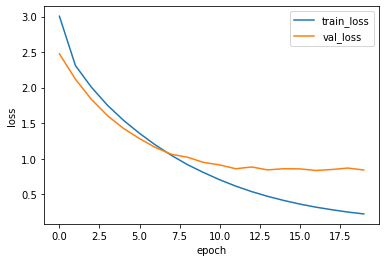

In [37]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

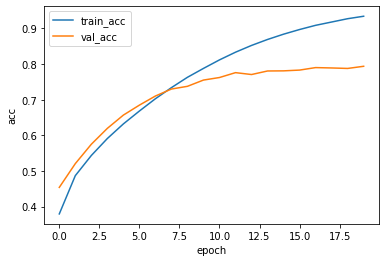

In [40]:
plt.plot(acc_plot, label='train_acc')
plt.plot(val_acc_plot, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [41]:
def evaluate(imgs):
    transformer.to(device)
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = torch.tensor([tokenizer.txt2idx['<sos>']] * imgs.size(0), dtype=torch.long).to(device)
    output = decoder_input.unsqueeze(1).to(device)
    enc_output = None
    for i in range(max_length+1):
        # predictions.shape == (batch_size, seq_len, vocab_size)
        with torch.no_grad():
            predictions, attention_weights, enc_output = transformer([imgs, output, enc_output])
        
        # select the last token from the seq_len dimension
        predictions_ = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = torch.tensor(torch.argmax(predictions_, axis=-1), dtype=torch.int32)
        
        output = torch.cat([output, predicted_id], dim=-1)
    output = output.cpu().numpy()
    
    summary_list = []
    token_list = []
    for token in output:
        summary = tokenizer.convert(token)
        summary_list.append(summary)
        token_list.append(token)
    
    return summary_list, token_list

In [42]:
tqdm_dataset = tqdm(enumerate(val_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['magnitude'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

157it [00:53,  2.96it/s]


In [ ]:
sub = pd.DataFrame(columns=['original', 'predict'])

for i, (a_t, p) in enumerate(zip(val_tokens, preds)):
    sub.loc[i, 'original'] = tokenizer.convert(a_t)
    sub.loc[i, 'predict'] = p
    print('정답 :', sub.loc[i, 'original'])
    print('예측 :', p)
#     print('토큰 :', tokens[i])
    print('=================================================================================')
    if i == 10:
        break

In [ ]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['magnitude'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

In [ ]:
submission['text'] = preds
submission.head()
submission.to_csv('dacon_baseline_0927.csv', index=False)